In [85]:
# Multi-Algorithm Benchmarking: Graduation Prediction

## Objective
# Compare the performance of three classification algorithms on student graduation prediction:
# 1. **Logistic Regression** - Linear baseline model
# 2. **Decision Tree** - Single tree-based model
# 3. **Random Forest** - Ensemble of decision trees

# ## Evaluation Metrics
# - **AUC-ROC**: Area under ROC curve (primary metric)
# - **Accuracy**: Overall classification accuracy
# - **Precision**: Correctness of positive predictions
# - **Recall**: Ability to find all positive cases
# - **F1-Score**: Harmonic mean of precision and recall
# - **Training Time**: Computational efficiency

In [86]:
## 1. Setup and Imports


In [87]:
# System path configuration
import os
import sys

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_root)

# Database connection
from src.db.core import get_db_connection

# Data processing
import pandas as pd
import numpy as np
from datetime import datetime
import time

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print(f"Working directory: {os.getcwd()}")


✓ All libraries imported successfully
Working directory: c:\Users\Justyn Lim\Desktop\Python\FYP\SoC-SMS\src\services


In [88]:
## 2. Data Extraction

#Use the same SQL query from the original training script to extract features and labels.


In [89]:
def extract_features_and_labels():
    """Query database to get features and labels for graduated students"""
    
    conn = get_db_connection()

    query = """
    WITH student_entry_year AS (
        SELECT 
            MATRIC_NO,
            CASE 
                WHEN MAX(CASE WHEN ATTEMPT_1 = 'Exempted' THEN 1 ELSE 0 END) = 1 
                THEN 2
                ELSE 1
            END AS entry_year_level,
            CASE 
                WHEN MAX(CASE WHEN ATTEMPT_1 = 'Exempted' THEN 1 ELSE 0 END) = 1 
                THEN 2
                ELSE 3
            END AS expected_years
        FROM STUDENT_SCORE
        GROUP BY MATRIC_NO
    ),

    course_attempt_details AS (
        SELECT 
            MATRIC_NO,
            COURSE_CODE,
            ATTEMPT_1,
            ATTEMPT_2,
            ATTEMPT_3,
            
            CASE 
                WHEN ATTEMPT_1 NOT IN ('-', 'Exempted') 
                THEN 1 ELSE 0 
            END +
            CASE 
                WHEN ATTEMPT_2 != '-' 
                THEN 1 ELSE 0 
            END +
            CASE 
                WHEN ATTEMPT_3 NOT IN ('-', 'NULL')
                THEN 1 ELSE 0 
            END AS attempts_for_course,
            
            CASE 
                WHEN ATTEMPT_1 NOT IN ('Exempted', '-') 
                     AND ISNUMERIC(ATTEMPT_1) = 1 
                     AND CAST(ATTEMPT_1 AS FLOAT) < 40
                THEN 1 ELSE 0 
            END AS failed_first_attempt,
            
            CASE WHEN ATTEMPT_1 = 'Exempted' THEN 1 ELSE 0 END AS is_exempted,
            
            CASE 
                WHEN ATTEMPT_1 NOT IN ('Exempted', '-')
                     AND ISNUMERIC(ATTEMPT_1) = 1 
                THEN CAST(ATTEMPT_1 AS FLOAT)
                ELSE NULL
            END AS first_attempt_score,
            
            CASE 
                WHEN ATTEMPT_3 NOT IN ('-', 'NULL')
                     AND ISNUMERIC(ATTEMPT_3) = 1 
                THEN CAST(ATTEMPT_3 AS FLOAT)
                
                WHEN ATTEMPT_2 != '-'
                     AND ISNUMERIC(ATTEMPT_2) = 1 
                THEN CAST(ATTEMPT_2 AS FLOAT)
                
                WHEN ATTEMPT_1 NOT IN ('Exempted', '-')
                     AND ISNUMERIC(ATTEMPT_1) = 1 
                THEN CAST(ATTEMPT_1 AS FLOAT)
                
                ELSE NULL
            END AS final_score,
            
            CASE 
                WHEN (
                    (ATTEMPT_3 NOT IN ('-', 'NULL') AND ISNUMERIC(ATTEMPT_3) = 1 AND CAST(ATTEMPT_3 AS FLOAT) >= 40)
                    OR (ATTEMPT_2 != '-' AND ISNUMERIC(ATTEMPT_2) = 1 AND CAST(ATTEMPT_2 AS FLOAT) >= 40)
                    OR (ATTEMPT_1 NOT IN ('Exempted', '-') AND ISNUMERIC(ATTEMPT_1) = 1 AND CAST(ATTEMPT_1 AS FLOAT) >= 40)
                )
                THEN 1 ELSE 0 
            END AS eventually_passed
            
        FROM STUDENT_SCORE
    ),

    student_features_enhanced AS (
        SELECT 
            MATRIC_NO,
            
            COUNT(DISTINCT COURSE_CODE) as total_courses,
            SUM(is_exempted) as exempted_courses,
            COUNT(DISTINCT COURSE_CODE) - SUM(is_exempted) as actual_courses_taken,
            
            SUM(CASE WHEN attempts_for_course = 1 THEN 1 ELSE 0 END) as courses_passed_first_attempt,
            SUM(CASE WHEN attempts_for_course = 2 THEN 1 ELSE 0 END) as courses_with_2_attempts,
            SUM(CASE WHEN attempts_for_course = 3 THEN 1 ELSE 0 END) as courses_with_3_attempts,
            SUM(CASE WHEN attempts_for_course >= 2 THEN 1 ELSE 0 END) as total_courses_needing_resits,
            
            SUM(failed_first_attempt) as total_first_attempt_failures,
            SUM(CASE WHEN failed_first_attempt = 1 AND eventually_passed = 0 THEN 1 ELSE 0 END) as courses_never_passed,
            SUM(CASE WHEN failed_first_attempt = 1 AND eventually_passed = 1 THEN 1 ELSE 0 END) as courses_passed_after_failing,
            
            AVG(first_attempt_score) as avg_first_attempt_score,
            MIN(first_attempt_score) as lowest_first_attempt_score,
            STDEV(first_attempt_score) as first_attempt_score_std_dev,
            
            AVG(final_score) as avg_final_score,
            MIN(final_score) as lowest_final_score,
            MAX(final_score) as highest_final_score,
            
            SUM(CASE WHEN first_attempt_score >= 70 THEN 1 ELSE 0 END) as courses_with_distinction_first_attempt,
            SUM(CASE WHEN first_attempt_score >= 40 AND first_attempt_score < 50 THEN 1 ELSE 0 END) as courses_barely_passed_first_attempt,
            SUM(CASE WHEN final_score = 40 AND attempts_for_course > 1 THEN 1 ELSE 0 END) as courses_capped_at_40,
            SUM(CASE WHEN final_score < 40 THEN 1 ELSE 0 END) as courses_still_failing
            
        FROM course_attempt_details
        GROUP BY MATRIC_NO
    ),

    graduation_labels AS (
        SELECT 
            s.MATRIC_NO,
            s.COHORT,
            s.GRADUATED_ON,
            sey.entry_year_level,
            sey.expected_years,
            
            DATEPART(YEAR, s.COHORT) AS entry_year,
            DATEPART(MONTH, s.COHORT) AS entry_month,
            
            2000 + CAST(SUBSTRING(s.GRADUATED_ON, 2, 2) AS INT) AS grad_year,
            CAST(SUBSTRING(s.GRADUATED_ON, 5, 1) AS INT) AS grad_month,
            
            DATEPART(YEAR, DATEADD(YEAR, sey.expected_years, s.COHORT)) AS expected_grad_year,
            DATEPART(MONTH, s.COHORT) AS expected_grad_month,
            
            CASE 
                WHEN 2000 + CAST(SUBSTRING(s.GRADUATED_ON, 2, 2) AS INT) < DATEPART(YEAR, DATEADD(YEAR, sey.expected_years, s.COHORT)) THEN 1
                WHEN 2000 + CAST(SUBSTRING(s.GRADUATED_ON, 2, 2) AS INT) = DATEPART(YEAR, DATEADD(YEAR, sey.expected_years, s.COHORT)) 
                     AND CAST(SUBSTRING(s.GRADUATED_ON, 5, 1) AS INT) <= DATEPART(MONTH, s.COHORT) THEN 1
                ELSE 0
            END AS on_time
            
        FROM STUDENTS s
        INNER JOIN student_entry_year sey ON s.MATRIC_NO = sey.MATRIC_NO
        WHERE 
            s.STUDENT_STATUS = 'Graduate'
            AND s.GRADUATED_ON != '-'
            AND s.GRADUATED_ON IS NOT NULL
    )

    SELECT 
        gl.*,
        
        sfe.total_courses,
        sfe.exempted_courses,
        sfe.actual_courses_taken,
        sfe.courses_passed_first_attempt,
        sfe.courses_with_2_attempts,
        sfe.courses_with_3_attempts,
        sfe.total_courses_needing_resits,
        sfe.total_first_attempt_failures,
        sfe.courses_never_passed,
        sfe.courses_passed_after_failing,
        sfe.avg_first_attempt_score,
        sfe.lowest_first_attempt_score,
        sfe.first_attempt_score_std_dev,
        sfe.avg_final_score,
        sfe.lowest_final_score,
        sfe.highest_final_score,
        sfe.courses_with_distinction_first_attempt,
        sfe.courses_barely_passed_first_attempt,
        sfe.courses_capped_at_40,
        sfe.courses_still_failing,
        
        CAST(sfe.courses_passed_first_attempt AS FLOAT) / NULLIF(sfe.actual_courses_taken, 0) as first_attempt_pass_rate,
        CAST(sfe.total_courses_needing_resits AS FLOAT) / NULLIF(sfe.actual_courses_taken, 0) as resit_rate,
        CAST(sfe.total_first_attempt_failures AS FLOAT) / NULLIF(sfe.actual_courses_taken, 0) as first_attempt_failure_rate,
        CAST(sfe.courses_with_3_attempts AS FLOAT) / NULLIF(sfe.total_courses_needing_resits, 0) as third_attempt_rate,
        CAST(sfe.courses_capped_at_40 AS FLOAT) / NULLIF(sfe.total_courses_needing_resits, 0) as resit_success_rate
        
    FROM graduation_labels gl
    INNER JOIN student_features_enhanced sfe ON gl.MATRIC_NO = sfe.MATRIC_NO
    ORDER BY gl.MATRIC_NO
    """
    
    df = pd.read_sql(query, conn)
    conn.close()
    
    print(f"✓ Extracted {len(df)} training records")
    return df

# Execute data extraction
df = extract_features_and_labels()


✓ Extracted 70 training records


In [90]:
## 3. Data Preparation


In [118]:
# Check class distribution
on_time_count = df['on_time'].sum()
late_count = len(df) - on_time_count

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(f"  - On-time graduates: {on_time_count} ({on_time_count/len(df)*100:.1f}%)")
print(f"  - Late graduates: {late_count} ({late_count/len(df)*100:.1f}%)")



print(f"\nClass Imbalance Metrics:")
if late_count > 0 and on_time_count > 0:
    # Imbalance ratio (majority / minority)
    imbalance_ratio = on_time_count / late_count
    print(f"  - Imbalance Ratio: {imbalance_ratio:.2f}:1 (majority:minority)")

    # Severity classification
    if imbalance_ratio <= 1.5:
        severity = "Balanced"
    elif imbalance_ratio <= 3:
        severity = "Slightly Imbalanced"
    elif imbalance_ratio <= 9:
        severity = "Moderately Imbalanced"
    else:
        severity = "Highly Imbalanced"
    
    print(f"  - Imbalance Severity: {severity}")

# Validate we have both classes
if late_count == 0 or on_time_count == 0:
    raise ValueError("Cannot train - need both on-time and late graduates!")

# Define feature columns (same as original)
feature_cols = [
    # Basic
    'entry_year_level',
    'total_courses',
    'actual_courses_taken',
    
    # Attempt patterns
    'courses_passed_first_attempt',
    'courses_with_2_attempts',
    'courses_with_3_attempts',
    'total_courses_needing_resits',
    
    # Failure patterns
    'total_first_attempt_failures',
    'courses_never_passed',
    'courses_passed_after_failing',
    
    # First attempt performance
    'avg_first_attempt_score',
    'lowest_first_attempt_score',
    'first_attempt_score_std_dev',
    
    # Final performance
    'avg_final_score',
    'lowest_final_score',
    
    # Success indicators
    'courses_with_distinction_first_attempt',
    'courses_barely_passed_first_attempt',
    'courses_capped_at_40',
    
    # Derived ratios
    'first_attempt_pass_rate',
    'resit_rate',
    'first_attempt_failure_rate',
    'third_attempt_rate',
    'resit_success_rate'
]

# Prepare feature matrix and target
X = df[feature_cols].fillna(0)
y = df['on_time']

print(f"\n✓ Feature matrix: {X.shape}")
print(f"✓ Target variable: {y.shape}")


Dataset shape: (70, 37)

Class distribution:
  - On-time graduates: 67 (95.7%)
  - Late graduates: 3 (4.3%)

Class Imbalance Metrics:
  - Imbalance Ratio: 22.33:1 (majority:minority)
  - Imbalance Severity: Highly Imbalanced

✓ Feature matrix: (70, 23)
✓ Target variable: (70,)


In [92]:
## 4. Train-Test Split

#Split data with stratification to maintain class balance in both sets.


In [93]:
# Determine if we should create a test set
if len(df) < 20 or late_count < 5 or on_time_count < 5:
    print(f"⚠ Small dataset detected ({len(df)} samples)")
    print("Using all data for training - cross-validation will be used for evaluation")
    X_train, X_test = X, None
    y_train, y_test = y, None
    use_test_set = False
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    use_test_set = True
    print(f"✓ Training set: {len(X_train)} samples")
    print(f"✓ Test set: {len(X_test)} samples")

print(f"\nTraining set class distribution:")
print(y_train.value_counts())


⚠ Small dataset detected (70 samples)
Using all data for training - cross-validation will be used for evaluation

Training set class distribution:
on_time
1    67
0     3
Name: count, dtype: int64


In [94]:
## 5. Model Configuration

#Initialize all four algorithms with appropriate hyperparameters.


In [95]:
# Calculate class weights for imbalanced data
pos = y_train.sum()
neg = (y_train == 0).sum()
scale_pos_weight = max(1.0, neg / max(1, pos))

print(f"Class imbalance ratio: {scale_pos_weight:.2f}")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',  # Handle class imbalance
        solver='lbfgs'
    ),
    
    'Decision Tree': DecisionTreeClassifier(
        max_depth=5,  # Prevent overfitting
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced'
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
}

print("\n✓ Models initialized:")
for name in models.keys():
    print(f"  - {name}")


Class imbalance ratio: 1.00

✓ Models initialized:
  - Logistic Regression
  - Decision Tree
  - Random Forest


In [96]:
## 6. Model Training and Evaluation

# Train all models and collect performance metrics.


In [97]:
# Storage for results
results = {
    'model': [],
    'auc_roc': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'training_time': []
}

trained_models = {}

print("=" * 70)
print("TRAINING AND EVALUATING MODELS")
print("=" * 70)

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")
    
    # Train model and measure time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Store trained model
    trained_models[name] = model
    
    # Make predictions
    if use_test_set:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        y_true = y_test
        eval_set = "Test Set"
    else:
        # Use cross-validation for small datasets
        cv = StratifiedKFold(n_splits=min(3, min(pos, neg)), shuffle=True, random_state=42)
        y_pred_proba = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        y_pred = model.predict(X_train)
        y_true = y_train
        eval_set = "Training Set (with CV for AUC)"
    
    # Calculate metrics
    if use_test_set:
        auc = roc_auc_score(y_true, y_pred_proba)
    else:
        auc = y_pred_proba.mean()  # Mean CV score
        y_pred_proba = model.predict_proba(X_train)[:, 1]  # For other metrics
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Store results
    results['model'].append(name)
    results['auc_roc'].append(auc)
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1_score'].append(f1)
    results['training_time'].append(training_time)
    
    # Print results
    print(f"\n{eval_set} Performance:")
    print(f"  AUC-ROC:      {auc:.4f}")
    print(f"  Accuracy:     {accuracy:.4f}")
    print(f"  Precision:    {precision:.4f}")
    print(f"  Recall:       {recall:.4f}")
    print(f"  F1-Score:     {f1:.4f}")
    print(f"  Training Time: {training_time:.3f}s")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Late', 'On-time'], zero_division=0))

print("\n" + "=" * 70)
print("✓ ALL MODELS TRAINED")
print("=" * 70)


TRAINING AND EVALUATING MODELS

Training: Logistic Regression

Training Set (with CV for AUC) Performance:
  AUC-ROC:      0.9242
  Accuracy:     0.9857
  Precision:    1.0000
  Recall:       0.9851
  F1-Score:     0.9925
  Training Time: 0.012s

Classification Report:
              precision    recall  f1-score   support

        Late       0.75      1.00      0.86         3
     On-time       1.00      0.99      0.99        67

    accuracy                           0.99        70
   macro avg       0.88      0.99      0.92        70
weighted avg       0.99      0.99      0.99        70


Training: Decision Tree

Training Set (with CV for AUC) Performance:
  AUC-ROC:      0.9634
  Accuracy:     0.9714
  Precision:    1.0000
  Recall:       0.9701
  F1-Score:     0.9848
  Training Time: 0.002s

Classification Report:
              precision    recall  f1-score   support

        Late       0.60      1.00      0.75         3
     On-time       1.00      0.97      0.98        67

    ac

In [98]:
## 7. Results Summary

# Aggregate all metrics into a comparison table.


In [99]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Sort by AUC-ROC (primary metric)
results_df = results_df.sort_values('auc_roc', ascending=False).reset_index(drop=True)

# Add rank column
results_df.insert(0, 'rank', range(1, len(results_df) + 1))

# Display full results
print("=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)
print("\n")
print(results_df.to_string(index=False))
print("\n")

# Identify best model
best_model_name = results_df.iloc[0]['model']
best_auc = results_df.iloc[0]['auc_roc']

print(f"🏆 BEST MODEL: {best_model_name} (AUC-ROC: {best_auc:.4f})")


MODEL COMPARISON SUMMARY


 rank               model  auc_roc  accuracy  precision   recall  f1_score  training_time
    1       Random Forest 0.969697  0.942857        1.0 0.940299  0.969231       0.212501
    2       Decision Tree 0.963439  0.971429        1.0 0.970149  0.984848       0.002001
    3 Logistic Regression 0.924242  0.985714        1.0 0.985075  0.992481       0.012499


🏆 BEST MODEL: Random Forest (AUC-ROC: 0.9697)


In [100]:
## 8. Visualization: Performance Comparison


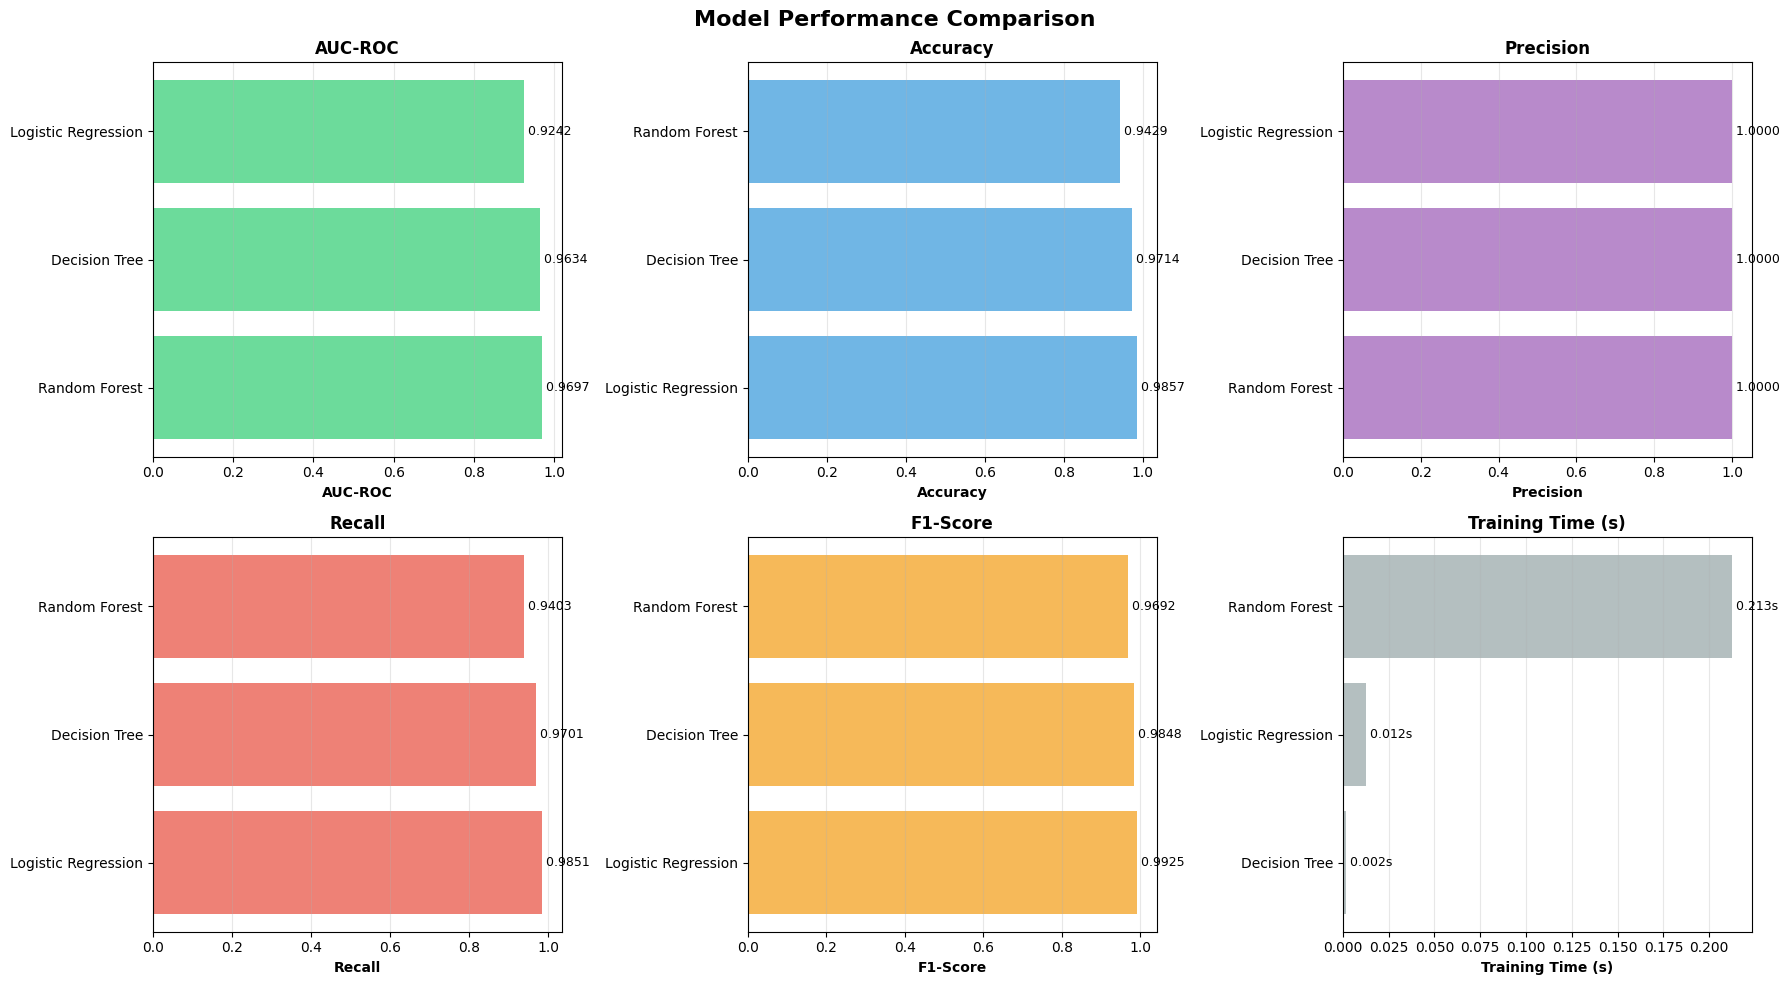

In [101]:
# Create subplots for different metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Metrics to plot
metrics = ['auc_roc', 'accuracy', 'precision', 'recall', 'f1_score', 'training_time']
titles = ['AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)']
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#95a5a6']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Sort by metric value
    sorted_df = results_df.sort_values(metric, ascending=(metric == 'training_time'))
    
    # Create bar plot
    bars = ax.barh(sorted_df['model'], sorted_df[metric], color=color, alpha=0.7)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, sorted_df[metric])):
        if metric == 'training_time':
            label = f'{value:.3f}s'
        else:
            label = f'{value:.4f}'
        ax.text(value, i, f' {label}', va='center', fontsize=9)
    
    ax.set_xlabel(title, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [102]:
## 9. ROC Curve Comparison

# Compare ROC curves for all models (only possible with test set).


In [103]:
if use_test_set:
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for each model
    for name, model in trained_models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.4f})')
    
    # Plot diagonal (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5000)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ ROC curve comparison requires a test set.")
    print("Dataset too small for train-test split - using cross-validation instead.")


⚠ ROC curve comparison requires a test set.
Dataset too small for train-test split - using cross-validation instead.


In [104]:
## 10. Confusion Matrices

# Visualize prediction errors for each model.


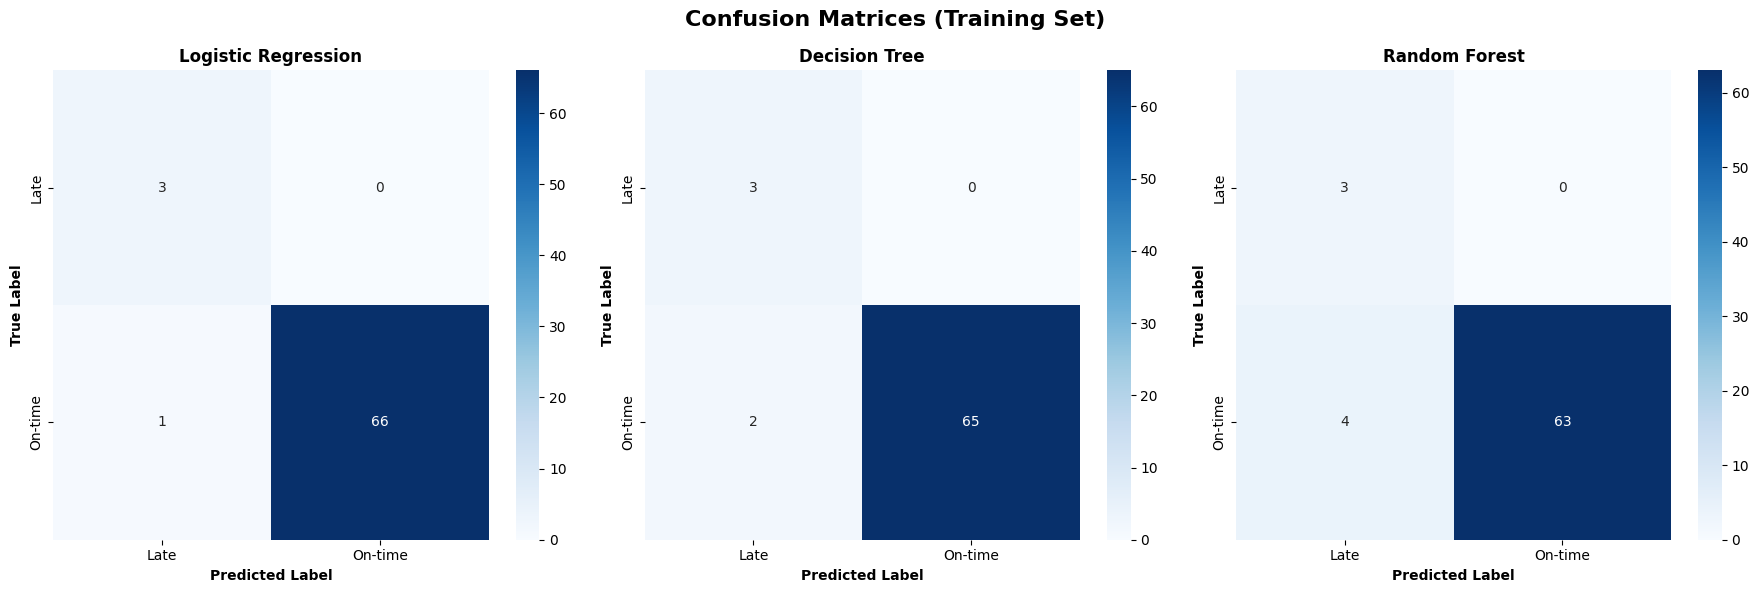

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Confusion Matrices (Test Set)' if use_test_set else 'Confusion Matrices (Training Set)', 
             fontsize=16, fontweight='bold')

for idx, (name, model) in enumerate(trained_models.items()):
    ax = axes[idx]
    
    # Get predictions
    if use_test_set:
        y_pred = model.predict(X_test)
        y_true = y_test
    else:
        y_pred = model.predict(X_train)
        y_true = y_train
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Late', 'On-time'], 
                yticklabels=['Late', 'On-time'],
                cbar=True)
    
    ax.set_xlabel('Predicted Label', fontweight='bold')
    ax.set_ylabel('True Label', fontweight='bold')
    ax.set_title(name, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [106]:
## 11. Feature Importance Comparison

# Compare feature importance across tree-based models (Decision Tree, Random Forest, XGBoost).


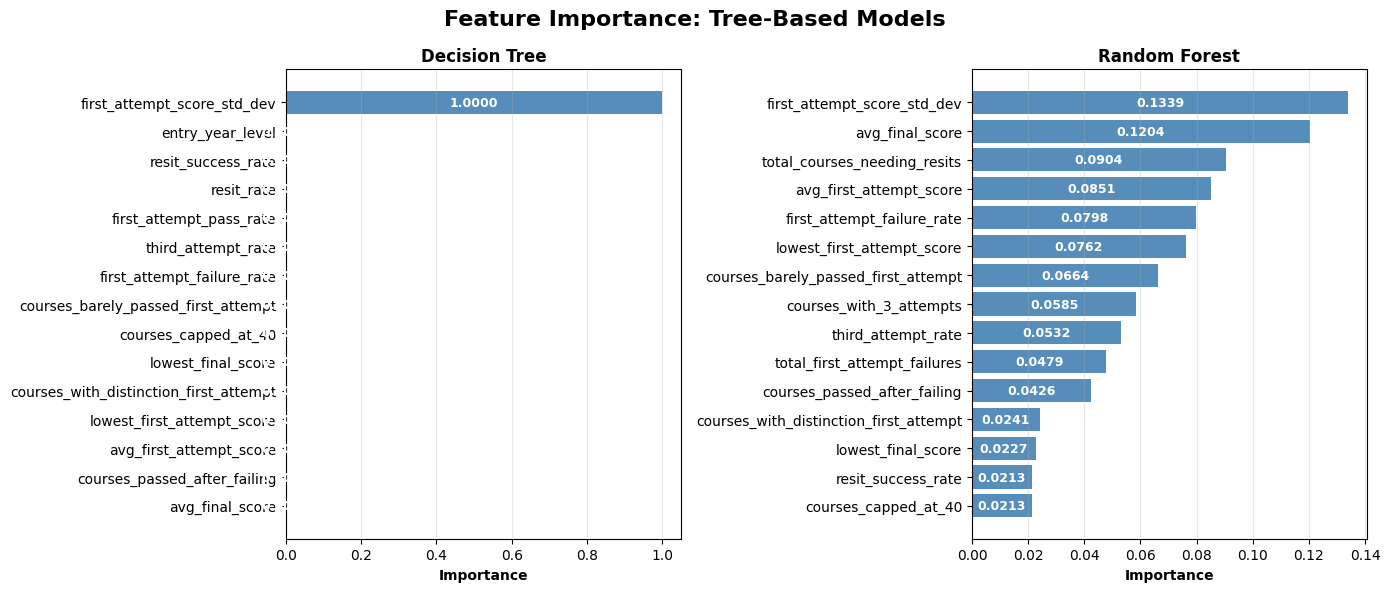

In [120]:
# Extract feature importance for tree-based models
tree_models = ['Decision Tree', 'Random Forest']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Feature Importance: Tree-Based Models', fontsize=16, fontweight='bold')

for idx, model_name in enumerate(tree_models):
    ax = axes[idx]
    model = trained_models[model_name]
    
    # Get feature importance
    importance = model.feature_importances_
    
    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=True)
    
    # Plot top 15 features
    top_n = min(15, len(feature_importance_df))
    top_features = feature_importance_df.tail(top_n)

    bars = ax.barh(top_features['feature'], top_features['importance'], color='steelblue', alpha=0.7)

    # Add value labels inside bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width * 0.5, bar.get_y() + bar.get_height()/2,  # Position at 50% of bar width
                f'{width:.4f}',
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

    
    ax.barh(top_features['feature'], top_features['importance'], color='steelblue', alpha=0.7)
    ax.set_xlabel('Importance', fontweight='bold')
    ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [108]:
# Print top 10 features for each tree-based model
print("=" * 90)
print("TOP 10 MOST IMPORTANT FEATURES BY MODEL")
print("=" * 90)

for model_name in tree_models:
    model = trained_models[model_name]
    importance = model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f"\n{model_name}:")
    print(feature_importance_df.head(10).to_string(index=False))


TOP 10 MOST IMPORTANT FEATURES BY MODEL

Decision Tree:
                     feature   importance
 first_attempt_score_std_dev 1.000000e+00
            entry_year_level 3.087083e-15
               total_courses 0.000000e+00
courses_passed_first_attempt 0.000000e+00
     courses_with_2_attempts 0.000000e+00
     courses_with_3_attempts 0.000000e+00
        actual_courses_taken 0.000000e+00
total_courses_needing_resits 0.000000e+00
total_first_attempt_failures 0.000000e+00
courses_passed_after_failing 0.000000e+00

Random Forest:
                            feature  importance
        first_attempt_score_std_dev    0.133908
                    avg_final_score    0.120419
       total_courses_needing_resits    0.090426
            avg_first_attempt_score    0.085106
         first_attempt_failure_rate    0.079847
         lowest_first_attempt_score    0.076207
courses_barely_passed_first_attempt    0.066360
            courses_with_3_attempts    0.058511
                 third_attempt_rat

In [109]:
## 11A. Logistic Regression Coefficients

# Logistic regression uses coefficients to indicate feature importance. Larger absolute values indicate stronger influence on predictions.


LOGISTIC REGRESSION FEATURE IMPORTANCE (Top 15)

Coefficients indicate the change in log-odds for a 1-unit increase:
  - Positive: Increases likelihood of on-time graduation
  - Negative: Decreases likelihood of on-time graduation
  - Larger absolute value: Stronger influence

                               feature  coefficient  abs_coefficient
          total_courses_needing_resits    -1.063724         1.063724
   courses_barely_passed_first_attempt    -0.902952         0.902952
          courses_passed_first_attempt     0.582282         0.582282
               courses_with_3_attempts    -0.566754         0.566754
           first_attempt_score_std_dev     0.532181         0.532181
               courses_with_2_attempts    -0.496970         0.496970
          courses_passed_after_failing    -0.462028         0.462028
          total_first_attempt_failures    -0.462028         0.462028
                  actual_courses_taken    -0.459716         0.459716
               avg_first_attempt

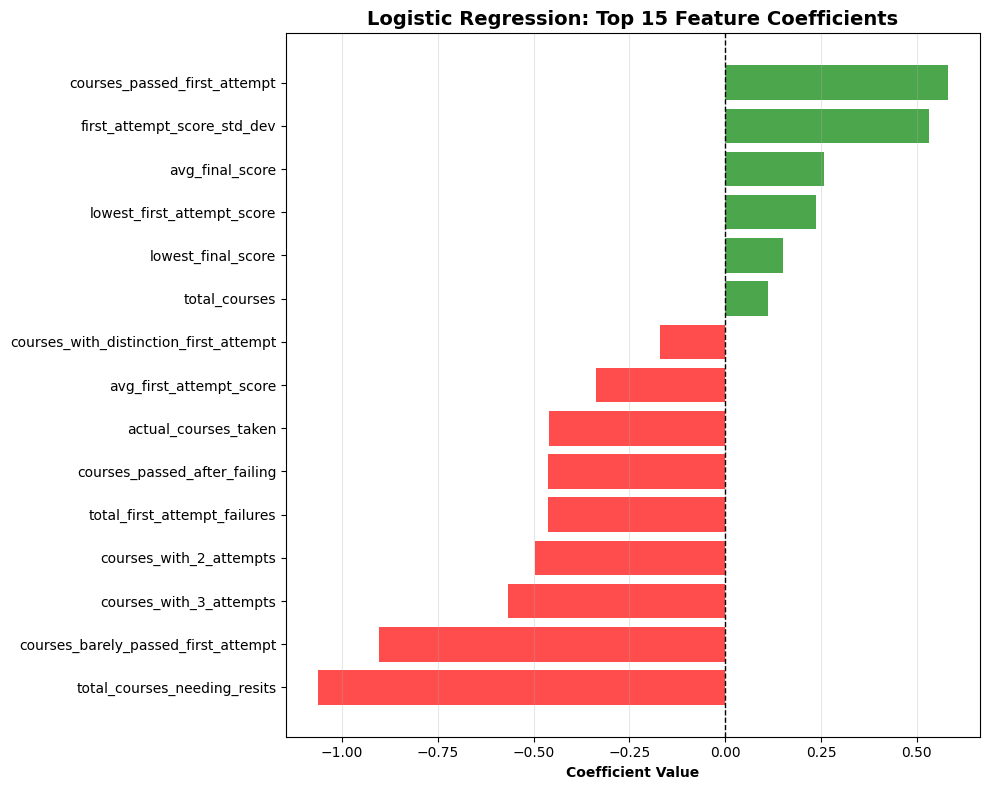

In [110]:
# Extract Logistic Regression coefficients
lr_model = trained_models['Logistic Regression']

# Get coefficients
coefficients = lr_model.coef_[0]  # [0] because binary classification

# Create DataFrame
lr_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("=" * 70)
print("LOGISTIC REGRESSION FEATURE IMPORTANCE (Top 15)")
print("=" * 70)
print("\nCoefficients indicate the change in log-odds for a 1-unit increase:")
print("  - Positive: Increases likelihood of on-time graduation")
print("  - Negative: Decreases likelihood of on-time graduation")
print("  - Larger absolute value: Stronger influence\n")

print(lr_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_15 = lr_importance.head(15).sort_values('coefficient')  # Sort by actual value for color

colors = ['red' if x < 0 else 'green' for x in top_15['coefficient']]
plt.barh(top_15['feature'], top_15['coefficient'], color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Coefficient Value', fontweight='bold')
plt.title('Logistic Regression: Top 15 Feature Coefficients', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [111]:
## 11B. Feature Importance Comparison

# Compare feature importance across all models:
# - **Logistic Regression**: Coefficients (linear relationships)
# - **Decision Tree & Random Forest**: Feature importances (non-linear patterns)


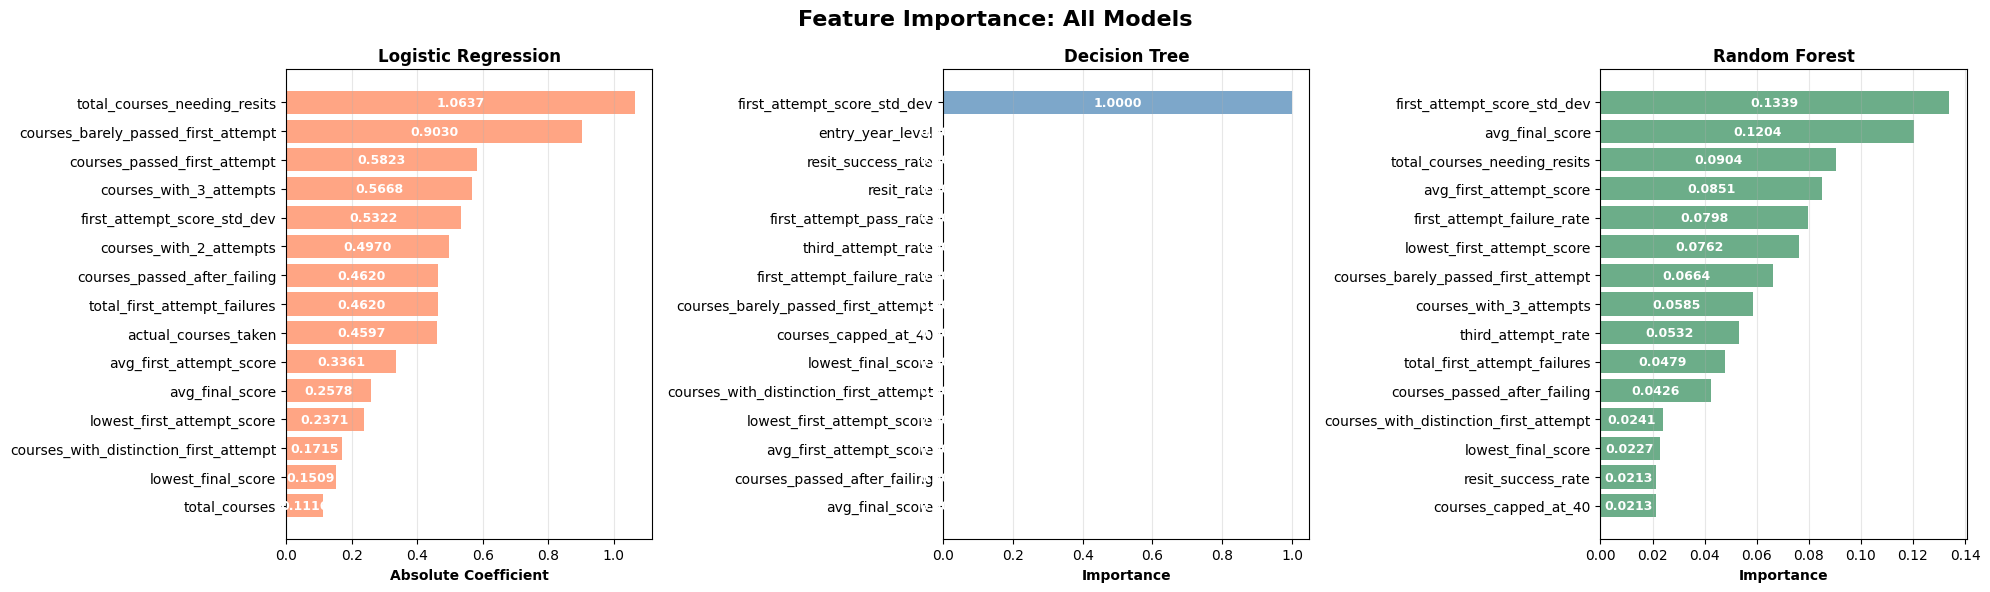

In [121]:
# Feature importance for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance: All Models', fontsize=16, fontweight='bold')

# 1. Logistic Regression (coefficients)
ax = axes[0]
lr_model = trained_models['Logistic Regression']
coefficients = lr_model.coef_[0]

lr_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(coefficients)  # Use absolute value for comparison
}).sort_values('importance', ascending=True)

top_n = min(15, len(lr_importance_df))
top_features = lr_importance_df.tail(top_n)

bars = ax.barh(top_features['feature'], top_features['importance'], color='coral', alpha=0.7)

# Add value labels inside bars
for bar in bars:
    width = bar.get_width()
    ax.text(width/2, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}',
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# ax.barh(top_features['feature'], top_features['importance'], color='coral', alpha=0.7)
ax.set_xlabel('Absolute Coefficient', fontweight='bold')
ax.set_title('Logistic Regression', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 2. Decision Tree
ax = axes[1]
dt_model = trained_models['Decision Tree']
importance = dt_model.feature_importances_

dt_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=True)

top_features = dt_importance_df.tail(top_n)
bars = ax.barh(top_features['feature'], top_features['importance'], color='steelblue', alpha=0.7)

# Add value labels inside bars
for bar in bars:
    width = bar.get_width()
    ax.text(width/2, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}',
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')

#ax.barh(top_features['feature'], top_features['importance'], color='steelblue', alpha=0.7)
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title('Decision Tree', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Random Forest
ax = axes[2]
rf_model = trained_models['Random Forest']
importance = rf_model.feature_importances_

rf_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=True)

top_features = rf_importance_df.tail(top_n)
bars = ax.barh(top_features['feature'], top_features['importance'], color='seagreen', alpha=0.7)

# Add value labels inside bars
for bar in bars:
    width = bar.get_width()
    ax.text(width/2, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}',
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')
#ax.barh(top_features['feature'], top_features['importance'], color='seagreen', alpha=0.7)
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title('Random Forest', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [113]:
## 12. Statistical Significance Testing

# Compare models using cross-validation to assess statistical significance (for datasets with sufficient samples).


In [114]:
if len(df) >= 30 and min(pos, neg) >= 10:
    print("Performing 5-Fold Cross-Validation for Statistical Comparison...")
    print("=" * 70)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = {}
    
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        cv_results[name] = scores
        
        print(f"\n{name}:")
        print(f"  Mean AUC: {scores.mean():.4f}")
        print(f"  Std Dev:  {scores.std():.4f}")
        print(f"  Min:      {scores.min():.4f}")
        print(f"  Max:      {scores.max():.4f}")
    
    # Visualize CV results
    plt.figure(figsize=(12, 6))
    
    positions = range(1, len(cv_results) + 1)
    box_data = [cv_results[name] for name in models.keys()]
    
    bp = plt.boxplot(box_data, positions=positions, labels=models.keys(), patch_artist=True)
    
    # Color boxes
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel('AUC-ROC Score', fontweight='bold', fontsize=12)
    plt.title('5-Fold Cross-Validation: Model Performance Distribution', 
              fontweight='bold', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠ Dataset too small for meaningful cross-validation statistical testing")
    print(f"Current: {len(df)} samples, Need: ≥30 samples with ≥10 per class")


⚠ Dataset too small for meaningful cross-validation statistical testing
Current: 70 samples, Need: ≥30 samples with ≥10 per class


In [115]:
## 13. Model Insights and Recommendations

### Key Findings


In [116]:
print("=" * 90)
print("MODEL BENCHMARKING INSIGHTS")
print("=" * 90)

# Best model by metric
best_by_metric = {
    'AUC-ROC': results_df.loc[results_df['auc_roc'].idxmax(), 'model'],
    'Accuracy': results_df.loc[results_df['accuracy'].idxmax(), 'model'],
    'Precision': results_df.loc[results_df['precision'].idxmax(), 'model'],
    'Recall': results_df.loc[results_df['recall'].idxmax(), 'model'],
    'F1-Score': results_df.loc[results_df['f1_score'].idxmax(), 'model'],
    'Speed (fastest)': results_df.loc[results_df['training_time'].idxmin(), 'model']
}

print("\n📊 Best Model by Metric:")
for metric, model in best_by_metric.items():
    value = results_df[results_df['model'] == model].iloc[0]
    if metric == 'Speed (fastest)':
        print(f"  {metric:20s}: {model:25s} ({value['training_time']:.3f}s)")
    else:
        metric_key = metric.lower().replace('-', '_').replace(' (fastest)', '')
        if metric_key in value:
            print(f"  {metric:20s}: {model:25s} ({value[metric_key]:.4f})")

# Overall recommendation
print(f"\n🏆 RECOMMENDED MODEL: {best_model_name}")
print(f"   Reason: Highest AUC-ROC score ({best_auc:.4f})")

# Performance gaps
auc_gap = results_df.iloc[0]['auc_roc'] - results_df.iloc[-1]['auc_roc']
print(f"\n📈 Performance Gap (best vs worst AUC): {auc_gap:.4f}")

if auc_gap < 0.05:
    print("   → Models perform similarly. Consider simpler model (Logistic Regression) for interpretability.")
elif auc_gap < 0.10:
    print("   → Moderate performance difference. Use best model if accuracy is priority.")
else:
    print("   → Significant performance difference. Recommended to use best performing model.")


MODEL BENCHMARKING INSIGHTS

📊 Best Model by Metric:
  AUC-ROC             : Random Forest             (0.9697)
  Accuracy            : Logistic Regression       (0.9857)
  Precision           : Random Forest             (1.0000)
  Recall              : Logistic Regression       (0.9851)
  F1-Score            : Logistic Regression       (0.9925)
  Speed (fastest)     : Decision Tree             (0.002s)

🏆 RECOMMENDED MODEL: Random Forest
   Reason: Highest AUC-ROC score (0.9697)

📈 Performance Gap (best vs worst AUC): 0.0455
   → Models perform similarly. Consider simpler model (Logistic Regression) for interpretability.
